In [1]:
from IPython.core.display import display, HTML, Javascript

# ----- Notebook Theme -----
color_map = ['#16a085', '#e8f6f3', '#d0ece7', '#a2d9ce', '#73c6b6', '#45b39d', 
                        '#16a085', '#138d75', '#117a65', '#0e6655', '#0b5345']

prompt = color_map[-1]
main_color = color_map[0]
strong_main_color = color_map[1]
custom_colors = [strong_main_color, main_color]

css_file = ''' 

div #notebook {
background-color: white;
line-height: 20px;
}

#notebook-container {
%s
margin-top: 2em;
padding-top: 2em;
border-top: 4px solid %s; /* light orange */
-webkit-box-shadow: 0px 0px 8px 2px rgba(224, 212, 226, 0.5); /* pink */
    box-shadow: 0px 0px 8px 2px rgba(224, 212, 226, 0.5); /* pink */
}

div .input {
margin-bottom: 1em;
}

.rendered_html h1, .rendered_html h2, .rendered_html h3, .rendered_html h4, .rendered_html h5, .rendered_html h6 {
color: %s; /* light orange */
font-weight: 600;
}

div.input_area {
border: none;
    background-color: %s; /* rgba(229, 143, 101, 0.1); light orange [exactly #E58F65] */
    border-top: 2px solid %s; /* light orange */
}

div.input_prompt {
color: %s; /* light blue */
}

div.output_prompt {
color: %s; /* strong orange */
}

div.cell.selected:before, div.cell.selected.jupyter-soft-selected:before {
background: %s; /* light orange */
}

div.cell.selected, div.cell.selected.jupyter-soft-selected {
    border-color: %s; /* light orange */
}

.edit_mode div.cell.selected:before {
background: %s; /* light orange */
}

.edit_mode div.cell.selected {
border-color: %s; /* light orange */

}
'''
def to_rgb(h): 
    return tuple(int(h[i:i+2], 16) for i in [0, 2, 4])

main_color_rgba = 'rgba(%s, %s, %s, 0.1)' % (to_rgb(main_color[1:]))
open('notebook.css', 'w').write(css_file % ('width: 95%;', main_color, main_color, main_color_rgba, main_color,  main_color, prompt, main_color, main_color, main_color, main_color))

def nb(): 
    return HTML("<style>" + open("notebook.css", "r").read() + "</style>")
nb()

C:\Users\avvoy\AppData\Local\Temp\ipykernel_18032\1016028258.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML, Javascript


In [2]:
# для автозагрузки изменений в модулях без необходимости перезагрузки kelner
%load_ext autoreload
%autoreload 2


# необходимо для корректного импорта своих модулей в JupyterLab
import sys
current_dir = sys.path[0]
project_dir = 'SF_DS_Pro'
last_position = current_dir.find(project_dir) + len(project_dir)
project_path = current_dir[:last_position]
sys.path.append(project_path)


%matplotlib inline
import matplotlib.pyplot as plt # библиотека визуализации
import seaborn as sns
# sns.set_style('whitegrid')
plt.style.use('ggplot')
sns.set(rc={'figure.figsize':(10, 8)})


import warnings
warnings.filterwarnings('ignore')


from IPython.core.display import HTML
HTML("""
<style>
.p-Widget.jp-OutputPrompt.jp-OutputArea-prompt:empty {
  padding: 0;
  border: 0;
}
</style>
""")

<img src="https://github.com/AILab-MLTools/LightAutoML/raw/master/imgs/LightAutoML_logo_big.png" alt="LightAutoML logo" style="width:70%;"/>

# LightAutoML baseline

Official LightAutoML github repository is [here](https://github.com/AILab-MLTools/LightAutoML). 

### Do not forget to put upvote for the notebook, follow me on Kaggle and the ⭐️ for github repo if you like it - one click for you, great pleasure for us ☺️ 
### If you miss the [simple baseline notebook](https://www.kaggle.com/code/alexryzhkov/clone-my-notebook) for this competition, please take a look and upvote it as well. 

In [3]:
s = '<iframe src="https://ghbtns.com/github-btn.html?user=sb-ai-lab&repo=LightAutoML&type=star&count=true&size=large" frameborder="0" scrolling="0" width="170" height="30" title="LightAutoML GitHub"></iframe>'
HTML(s)

## This notebook is the updated copy of our [Tutorial_1 from the GIT repository](https://github.com/AILab-MLTools/LightAutoML/blob/master/examples/tutorials/Tutorial_1_basics.ipynb). Please check our [tutorials folder](https://github.com/AILab-MLTools/LightAutoML/blob/master/examples/tutorials) if you are interested in other examples of LightAutoML functionality.

## 0. Prerequisites

### 0.0. install LightAutoML

In [4]:
%%capture
# !pip install lightautoml

# QUICK WORKAROUND FOR PROBLEM WITH PANDAS
# !pip install -U pandas

### 0.1. Import libraries

Here we will import the libraries we use in this kernel:
- Standard python libraries for timing, working with OS etc.
- Essential python DS libraries like numpy, pandas, scikit-learn and torch (the last we will use in the next cell)
- LightAutoML modules: `TabularAutoML` preset for AutoML model creation and Task class to setup what kind of ML problem we solve (binary/multiclass classification or regression)

In [5]:
# Standard python libraries
import os
import time

# Essential DS libraries
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import torch

# LightAutoML presets, task and report generation
from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.tasks import Task

import Handlers as hd

### 0.2. Constants

Here we setup the constants to use in the kernel:
- `N_THREADS` - number of vCPUs for LightAutoML model creation
- `N_FOLDS` - number of folds in LightAutoML inner CV
- `RANDOM_STATE` - random seed for better reproducibility
- `TEST_SIZE` - houldout data part size 
- `TIMEOUT` - limit in seconds for model to train
- `TARGET_NAME` - target column name in dataset

In [6]:
N_THREADS = 4
N_FOLDS = 5
RANDOM_STATE = 42
TEST_SIZE = 0.2
TIMEOUT = 30 * 60 # mins
TARGET_NAME = 'final_price'

### 0.3. Imported models setup

For better reproducibility fix numpy random seed with max number of threads for Torch (which usually try to use all the threads on server):

In [7]:
np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

### 0.4. Data loading
Let's check the data we have:

In [8]:
INPUT_DIR = 'data/'

In [9]:
train_data = pd.read_csv(INPUT_DIR + 'train_data.csv.zip')
print(train_data.shape)
train_data.head()

(35000, 15)


,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type,final_price
0,0,TOYOTA,Aqua s,Sedan,133000,2014,Automatic,4/5,Right-hand drive,Silver,Black,NaN,0,For Sale,3650.0
1,1,MERCEDES-BENZ,C 220,Sedan,24500,2010,Manual,4/5,Left wheel,Silver,Black,NaN,0,For Sale,6800.0
2,2,HYUNDAI,Veloster,Hatchback,31000,2016,Tiptronic,2/3,Left wheel,Silver,Black,KMHTC6AE3GU293912,1,For Sale,6300.0
3,3,HYUNDAI,Santa FE,Jeep,115459,2015,Automatic,4/5,Left wheel,Blue,Black,NaN,1,For Sale,14488.0
4,4,TOYOTA,CHR,Jeep,18950,2019,Automatic,4/5,Left wheel,Black,NaN,JTNKHMBX7K1030253,1,For Sale,5000.0


In [10]:
test_data = pd.read_csv(INPUT_DIR + 'test_data.csv.zip')
print(test_data.shape)
test_data.head()

(10697, 14)


,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type
0,35000,TOYOTA,Prius,Hatchback,323733,2012,Automatic,4/5,Left wheel,Grey,Black,JTDKN3DU6C5439638,1,For Sale
1,35001,HYUNDAI,Elantra,Sedan,112000,2013,Tiptronic,4/5,Left wheel,Grey,Black,SURATSHIA,1,For Sale
2,35002,LEXUS,NX 300,Jeep,16920,2018,Automatic,NaN,Left wheel,Brown,NaN,JTJYARBZ5J2104521,1,For Sale
3,35003,LEXUS,CT 200h,Hatchback,302742,2012,Automatic,4/5,Left wheel,White,NaN,JTHKD5BH4C2070945,1,For Sale
4,35004,TOYOTA,RAV 4,Jeep,1800,2002,Manual,4/5,Left wheel,Silver,Black,NaN,0,For Sale


In [11]:
submission = pd.read_csv(INPUT_DIR + 'sample_submission.csv')
print(submission.shape)
submission.head()

(10697, 2)


,row_ID,final_price
0,35000,0
1,35001,0
2,35002,0
3,35003,0
4,35004,0


### Step 0.5. Some user feature preparation

Be creative :)

In [12]:
train_data

,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type,final_price
0,0,TOYOTA,Aqua s,Sedan,133000,2014,Automatic,4/5,Right-hand drive,Silver,Black,NaN,0,For Sale,3650.0
1,1,MERCEDES-BENZ,C 220,Sedan,24500,2010,Manual,4/5,Left wheel,Silver,Black,NaN,0,For Sale,6800.0
2,2,HYUNDAI,Veloster,Hatchback,31000,2016,Tiptronic,2/3,Left wheel,Silver,Black,KMHTC6AE3GU293912,1,For Sale,6300.0
3,3,HYUNDAI,Santa FE,Jeep,115459,2015,Automatic,4/5,Left wheel,Blue,Black,NaN,1,For Sale,14488.0
4,4,TOYOTA,CHR,Jeep,18950,2019,Automatic,4/5,Left wheel,Black,NaN,JTNKHMBX7K1030253,1,For Sale,5000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34995,34995,FORD,Fusion,Sedan,87579,2013,Automatic,4/5,Left wheel,Black,NaN,3FA6P0K98DR308742,1,For Sale,6000.0
34996,34996,SSANGYONG,REXTON,Jeep,116092,2009,Automatic,4/5,Left wheel,Silver,Black,NaN,1,For Sale,9642.0
34997,34997,BMW,635,Sedan,43000,2015,Tiptronic,4/5,Left wheel,Grey,Grey,NaN,1,For Sale,23500.0
34998,34998,HYUNDAI,Tucson,Jeep,82139,2015,Automatic,4/5,Left wheel,White,Black,NaN,1,For Sale,12826.0


In [13]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35000 entries, 0 to 34999
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   row_ID                  35000 non-null  int64  
 1   vehicle_manufacturer    34999 non-null  object 
 2   vehicle_model           34993 non-null  object 
 3   vehicle_category        34999 non-null  object 
 4   current_mileage         35000 non-null  int64  
 5   vehicle_year            35000 non-null  int64  
 6   vehicle_gearbox_type    34999 non-null  object 
 7   doors_cnt               34255 non-null  object 
 8   wheels                  34999 non-null  object 
 9   vehicle_color           34599 non-null  object 
 10  vehicle_interior_color  28282 non-null  object 
 11  car_vin                 11488 non-null  object 
 12  car_leather_interior    35000 non-null  int64  
 13  deal_type               35000 non-null  object 
 14  final_price             35000 non-null

In [14]:
hd.get_columns_null_info_df(train_data)

,Column Name,Count Null,% Null,Type
0,row_ID,0,0.00,int64
1,vehicle_manufacturer,1,0.00,object
2,vehicle_model,7,0.02,object
3,vehicle_category,1,0.00,object
4,current_mileage,0,0.00,int64
5,vehicle_year,0,0.00,int64
6,vehicle_gearbox_type,1,0.00,object
7,doors_cnt,745,2.13,object
8,wheels,1,0.00,object
9,vehicle_color,401,1.15,object


In [15]:
hd.get_top_unique_values(train_data)

,Column Name,Count Unique,Top Value,Top Value %,Top Value Count
0,vehicle_manufacturer,68,TOYOTA,19.34,6768
1,vehicle_model,2224,Prius,6.72,2350
2,vehicle_category,11,Sedan,44.24,15483
3,current_mileage,11273,0,4.01,1403
4,vehicle_year,68,2012,11.20,3919
5,vehicle_gearbox_type,4,Automatic,69.40,24290
6,doors_cnt,3,4/5,94.72,32446
7,wheels,2,Left wheel,92.02,32207
8,vehicle_color,16,Black,26.17,9053
9,vehicle_interior_color,11,Black,74.55,21083


deal_type и doors_cnt самые неуникальные признаки.\
deal_type имеет два варианта, на продажу и аренда, нас же в принципе интересует предсказание цены продажи.\
Из тренировочной выборки удаляю авто которые под аренду. А сам столбец добавляю в исключения модели в роли.
doors_cnt просто добавляю в роли в качестве исключения.

In [16]:
train_data = train_data[train_data['deal_type'] == 'For Sale']

In [17]:
train_data

,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type,final_price
0,0,TOYOTA,Aqua s,Sedan,133000,2014,Automatic,4/5,Right-hand drive,Silver,Black,NaN,0,For Sale,3650.0
1,1,MERCEDES-BENZ,C 220,Sedan,24500,2010,Manual,4/5,Left wheel,Silver,Black,NaN,0,For Sale,6800.0
2,2,HYUNDAI,Veloster,Hatchback,31000,2016,Tiptronic,2/3,Left wheel,Silver,Black,KMHTC6AE3GU293912,1,For Sale,6300.0
3,3,HYUNDAI,Santa FE,Jeep,115459,2015,Automatic,4/5,Left wheel,Blue,Black,NaN,1,For Sale,14488.0
4,4,TOYOTA,CHR,Jeep,18950,2019,Automatic,4/5,Left wheel,Black,NaN,JTNKHMBX7K1030253,1,For Sale,5000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34995,34995,FORD,Fusion,Sedan,87579,2013,Automatic,4/5,Left wheel,Black,NaN,3FA6P0K98DR308742,1,For Sale,6000.0
34996,34996,SSANGYONG,REXTON,Jeep,116092,2009,Automatic,4/5,Left wheel,Silver,Black,NaN,1,For Sale,9642.0
34997,34997,BMW,635,Sedan,43000,2015,Tiptronic,4/5,Left wheel,Grey,Grey,NaN,1,For Sale,23500.0
34998,34998,HYUNDAI,Tucson,Jeep,82139,2015,Automatic,4/5,Left wheel,White,Black,NaN,1,For Sale,12826.0


Внимание на год выпуска, пробег и цену авто.
В годе выпуска нашал в тренировочных данных одну запись с нулевым годом. Она полностью кривая, там везде пусто. ЕЕ удалить.
Так же нашел две записи с нулевой ценой

Цену тоже надо проверить на предмет нормальности данных

### Изучаю год выпуска авто

In [82]:
train_data['vehicle_year'].value_counts()

2012    3871
2013    3707
2014    3584
2011    2752
2015    2605
        ... 
1978       1
1970       1
1968       1
1975       1
0          1
Name: vehicle_year, Length: 66, dtype: int64

In [83]:
train_data['vehicle_year'].describe()

count   34372.00
mean     2010.71
std        12.31
min         0.00
25%      2009.00
50%      2012.00
75%      2014.00
max      2020.00
Name: vehicle_year, dtype: float64

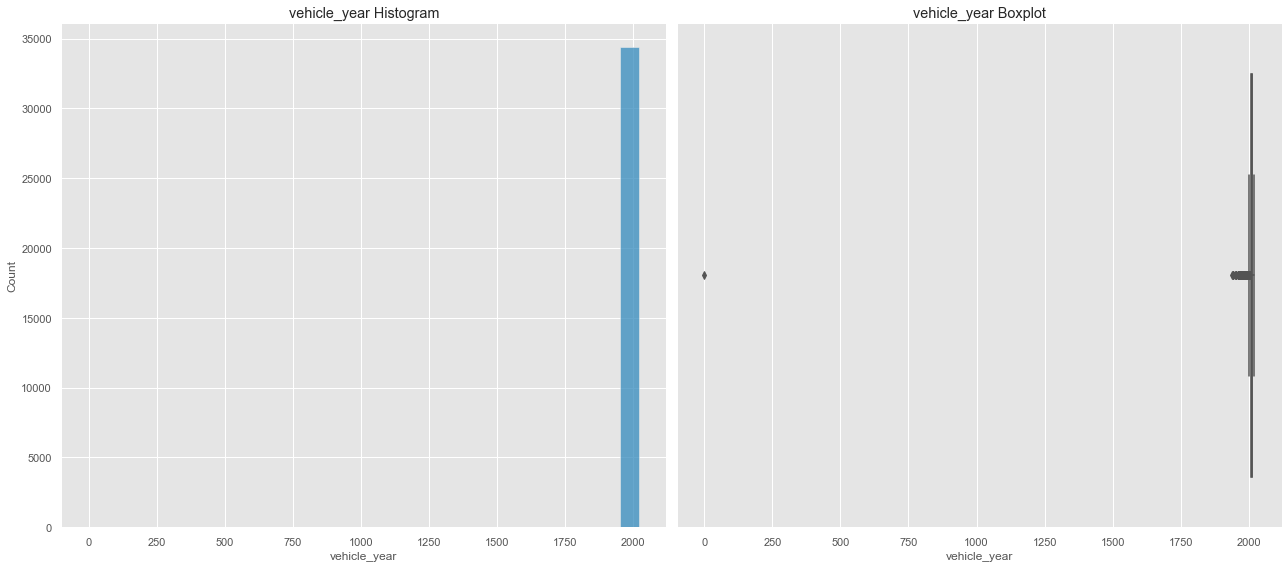

In [81]:
hd.Hist_and_Box_Plots(train_data, 'vehicle_year')

In [84]:
group_by_year = train_data.groupby('vehicle_year').agg({'vehicle_year': 'count'})
group_by_year.columns = ['Vehicle count']
group_by_year.head(20)

,Vehicle count
vehicle_year,
0,1
1940,1
1941,1
1943,2
1951,1
1953,3
1954,1
1960,1
1961,1


In [96]:
# Итак, запись с нулевом годом выпуска
train_data[train_data['vehicle_year'] == 0]

,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type,final_price
17918,17918,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,For Sale,0.00


In [97]:
# По индексу эту запись удаляю
ind = train_data[train_data['vehicle_year'] == 0].index
train_data.drop(ind, inplace=True)

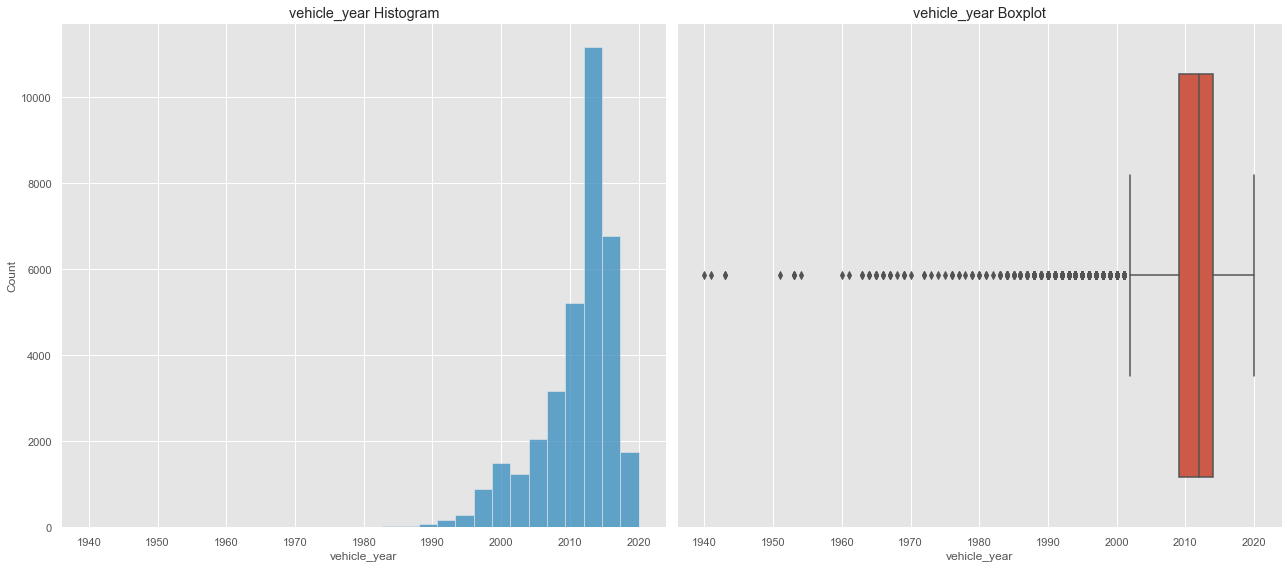

In [101]:
# Теперь смотрю на распределение годов
hd.Hist_and_Box_Plots(train_data, 'vehicle_year')


In [107]:
# Боксплот показывает выносы ниже 2001 года, посмотрю сколько там было авто, ну записей многовато, просто удалить не могу
train_data[train_data['vehicle_year'] < 2001]

,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type,final_price
15,15,VAZ,2103,Sedan,0,2000,Manual,4/5,Left wheel,White,Black,NaN,0,For Sale,1339.00
20,20,VOLKSWAGEN,Golf,Sedan,165248,1999,Manual,4/5,Left wheel,White,Black,NaN,0,For Sale,1700.00
68,68,SUBARU,Forester,Sedan,289848,2000,Tiptronic,4/5,Right-hand drive,Silver,Black,NaN,0,For Sale,1000.00
81,81,MERCEDES-BENZ,E 220,Sedan,220000,1997,Manual,4/5,Left wheel,Grey,Black,NaN,0,For Sale,2100.00
82,82,TOYOTA,Corolla spacio,Hatchback,299999,1998,Automatic,4/5,Right-hand drive,White,Grey,NaN,0,For Sale,700.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34950,34950,GAZ,3110,Sedan,146783,2000,Manual,4/5,Left wheel,Green,Black,NaN,0,For Sale,1000.00
34952,34952,NISSAN,Micra,Hatchback,666666666,1985,Manual,2/3,Left wheel,Sky blue,Beige,NaN,0,For Sale,500.00
34962,34962,LINCOLN,Navigator,Limousine,99000,1999,Automatic,4/5,Left wheel,White,Grey,NaN,1,For Sale,8000.00
34968,34968,AUDI,A4,Sedan,460000,1995,Manual,4/5,Right-hand drive,Grey,Carnelian red,NaN,0,For Sale,702.00


In [110]:
# Смотрю а что в тестовой выборке
test_data['vehicle_year'].describe()

count   10697.00
mean     2010.56
std        20.30
min         0.00
25%      2008.00
50%      2012.00
75%      2014.00
max      2020.00
Name: vehicle_year, dtype: float64

In [114]:
# Тоже есть авто с нулевым годом и тоже полностью пустые столбцы. Но ведь я не могу удалять из итоговой выборки столбцы, я как-то должне вручную это заполнить.
# Я просто итоговый сабмишн поправлю в ручную row_ID=37254 цену поставлю 0.
test_data[test_data['vehicle_year'] == 0]

,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type
2254,37254,NaN,NaN,NaN,0,0,NaN,NaN,NaN,NaN,NaN,NaN,0,For Sale


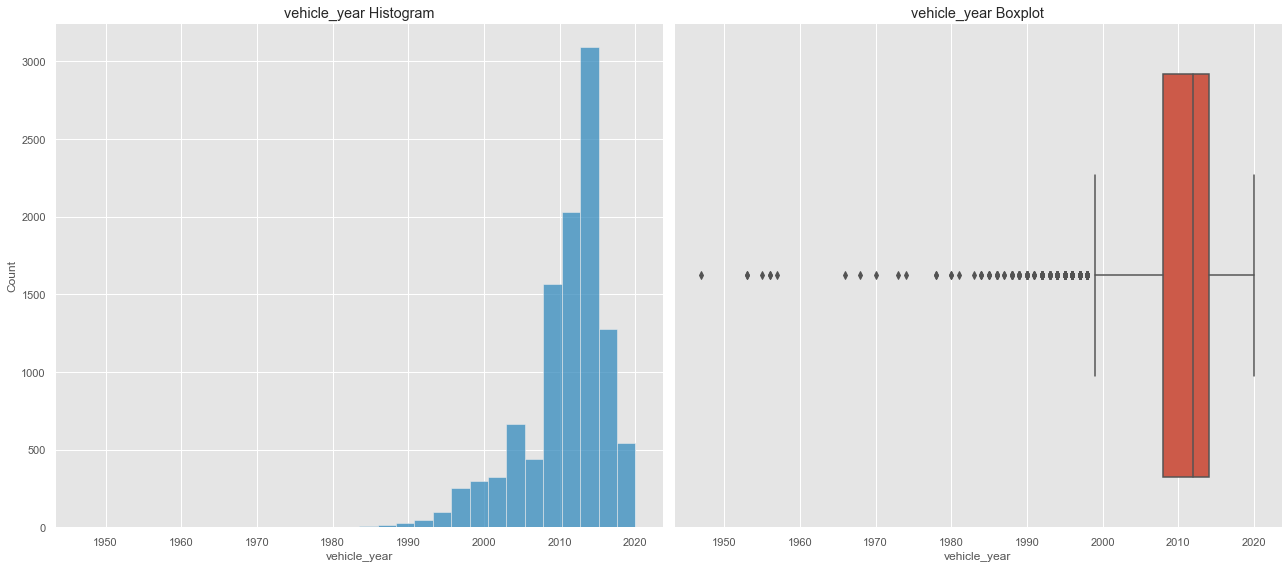

In [117]:
# Если посмотреть на год выпуска на тестовой выборке, исключив нулевой год, то получится примерно такое же распределение как и у тренировочной выборки
hd.Hist_and_Box_Plots(test_data.drop(test_data[test_data['vehicle_year'] == 0].index), 'vehicle_year')

In [99]:
train_data[train_data['final_price'] == 0]

,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_year,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type,final_price
7123,7123,CHEVROLET,Lacetti,Hatchback,200000,2006,Manual,4/5,Left wheel,Black,Grey,NaN,0,For Sale,0.00


In [64]:
train_data['vehicle_year'].describe()

count   34372.00
mean     2010.71
std        12.31
min         0.00
25%      2009.00
50%      2012.00
75%      2014.00
max      2020.00
Name: vehicle_year, dtype: float64

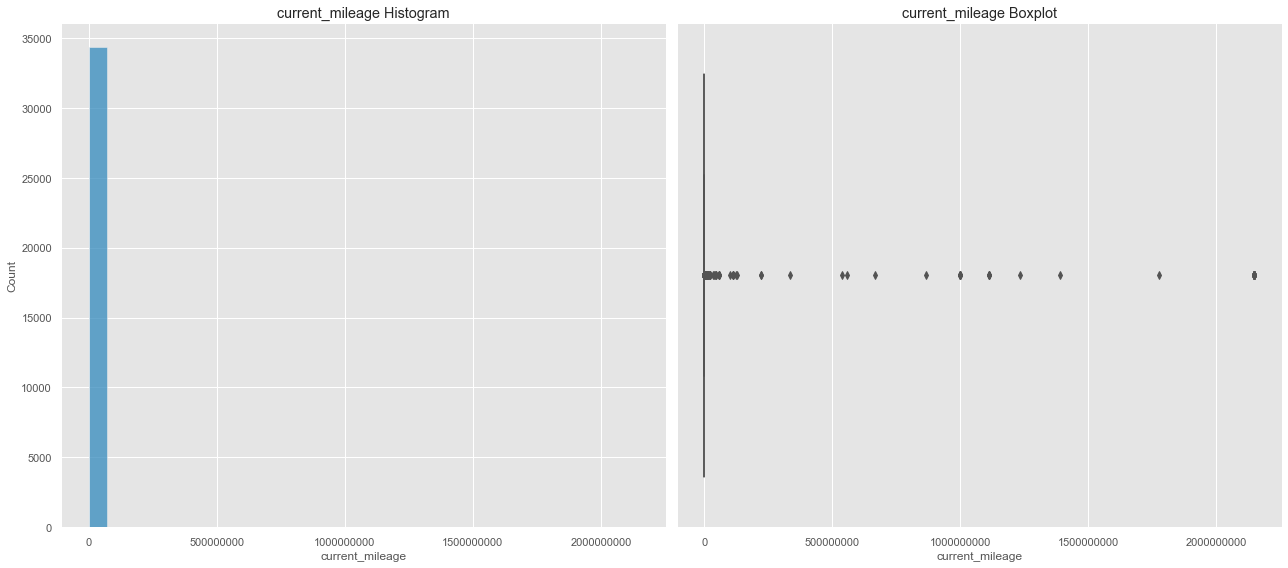

In [31]:
hd.Hist_and_Box_Plots(train_data, 'current_mileage')

<BarContainer object of 66 artists>

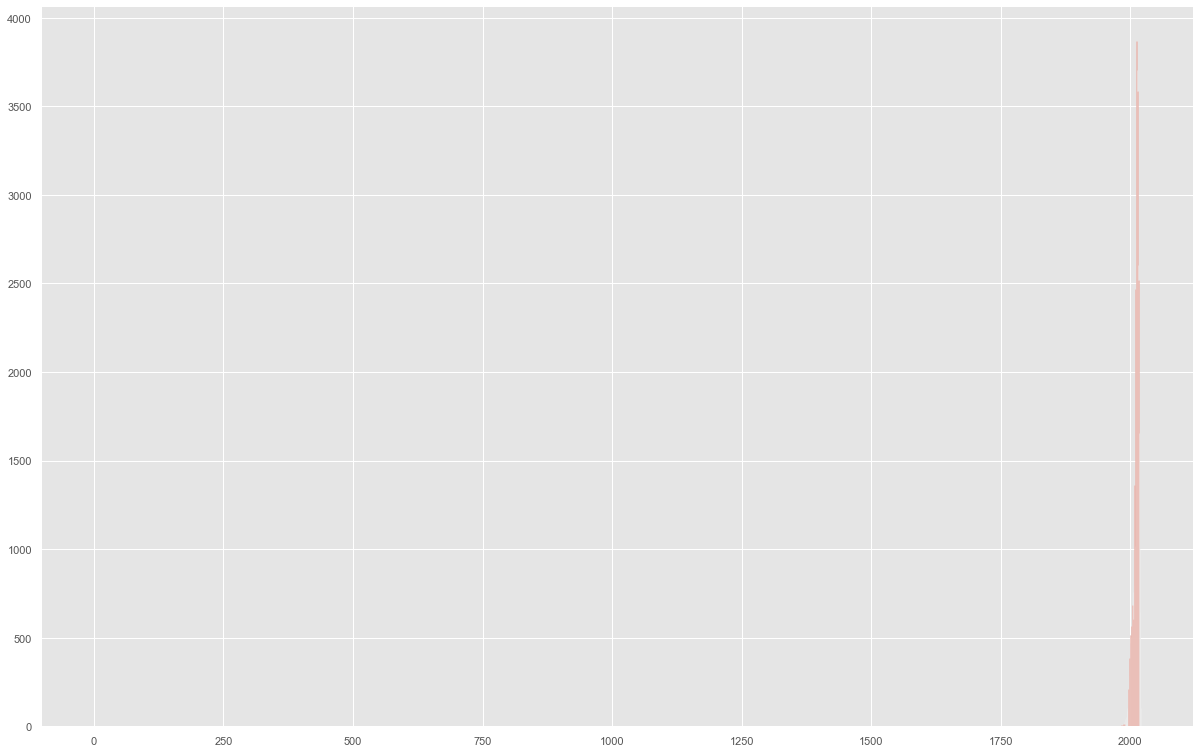

In [79]:
fig = plt.figure(figsize=(16, 10))
ax = fig.add_axes([0, 0, 1, 1])
ax.bar(group_by_year.index, group_by_year['Vehicle count'])

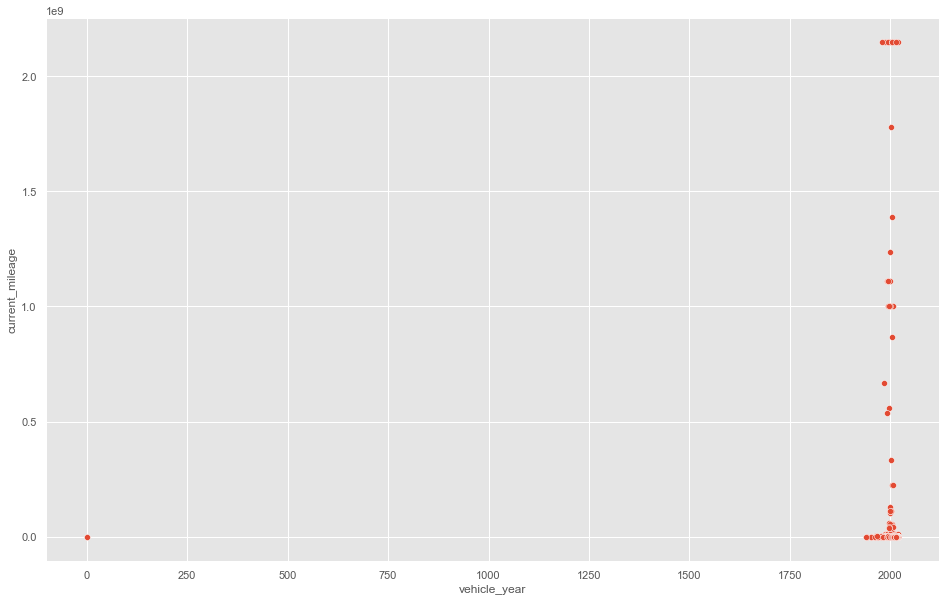

In [63]:
fig = plt.figure(figsize=(16, 10))
ax = sns.scatterplot(data = train_data, x = 'vehicle_year', y = 'current_mileage')

In [ ]:
colors = ['blue', 'yellow']
    
    ax = sns.heatmap(df[cols_null_perc].isnull(), cmap=colors, cbar=False)
    ax.set_title('Null Heatmap')

In [56]:
def null_heatmap_plot(df):
    cols_null_perc = df.isnull().mean() * 100
    cols_null_perc = cols_null_perc[cols_null_perc > 0]
    cols_null_perc = cols_null_perc.index.to_list()

    colors = ['blue', 'yellow']
    fig = plt.figure(figsize=(16, 10))
    ax = sns.heatmap(df[cols_null_perc].isnull(), cmap=colors, cbar=False)
    ax.set_title('Null Heatmap')

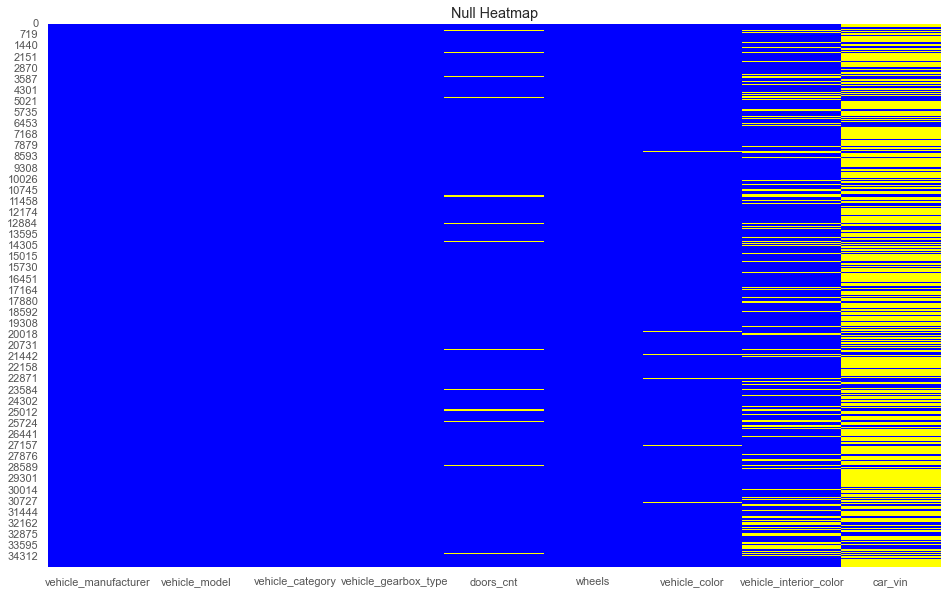

In [57]:
null_heatmap_plot(train_data)

In [49]:
def fill_interior_color(data):
    data['vehicle_interior_color'] = data['vehicle_interior_color'].fillna('UNKNOWN')
    
    return data

In [50]:
# train_data = fill_interior_color(train_data)
# test_data = fill_interior_color(test_data)

In [51]:
def fill_vehicle_manufacturer(data):
    data['vehicle_manufacturer'] = data['vehicle_manufacturer'].fillna('UNKNOWN')
    
    return data

In [52]:
# train_data = fill_vehicle_manufacturer(train_data)
# test_data = fill_vehicle_manufacturer(test_data)

### Работаю годом выпуска

In [84]:
def create_age_feature(data):
    data['vehicle_year'] = data['vehicle_year'].replace(0, data['vehicle_year'].median())
    data['vehicle_age'] = 2022 - data['vehicle_year']
    data = data.drop(columns=['vehicle_year'], axis=1)
    return data

In [85]:
%%time
train_data = create_age_feature(train_data)
test_data = create_age_feature(test_data)

CPU times: total: 0 ns
Wall time: 6.85 ms


### Пробег за год

In [56]:
def create_mil_per_year_feature(data):
    data['mil_per_year'] = (data['current_mileage'] / data['vehicle_age']).astype(int)
    return data

In [57]:
# train_data = create_mil_per_year_feature(train_data)
# test_data = create_mil_per_year_feature(test_data)

In [58]:
def create_qcut_age_feature(data):
    data['age_qcut'] = pd.qcut(data['vehicle_age'], q=4#, labels=['<=6', '7-8', '9-9', '10-11', '12-12','13-18', '19-83']
                              )
    data = data.drop(columns=['vehicle_age'], axis=1)
    return data

In [59]:
# train_data = create_qcut_age_feature(train_data)
# test_data = create_qcut_age_feature(test_data)

### Работаю с car_vin

In [60]:
# train_data['duplicate_vin'] = train_data['car_vin'].duplicated() & train_data['car_vin'].notna()

In [61]:
# train_data[train_data['duplicate_vin']]

In [62]:
def change_vin_features(data):
    # Заполняю пропуски
    data['car_vin'] = data['car_vin'].fillna('empty')
    # Удаляю пробелы по сторонам
    data['car_vin'] = data['car_vin'].map(lambda x: str(x).strip())
    
    data['car_vin'] = data['car_vin'].apply(lambda x: 'normal' if len(x) == 17 else 'empty')
    
    return data

In [63]:
%%time
# train_data = change_vin_features(train_data)
# test_data = change_vin_features(test_data)

CPU times: total: 0 ns
Wall time: 0 ns


### Отмечаю машины, которые были проданы несколько раз

In [64]:
def multiple_sell_feature(data):
    col_to_get_dup = list(data.columns)
    
    if 'row_ID' in col_to_get_dup:
        col_to_get_dup.remove('row_ID')

    if 'final_price' in col_to_get_dup:
        col_to_get_dup.remove('final_price')
    
    data['multiple_sell'] = data.duplicated(subset=col_to_get_dup)
    
    return data

In [65]:
%%time
# train_data = multiple_sell_feature(train_data)
# test_data = multiple_sell_feature(test_data)

CPU times: total: 0 ns
Wall time: 0 ns


### Попробую целевую переменную привести к целому типу, может это положительно скажется на моделе

In [86]:
train_data[TARGET_NAME] = train_data[TARGET_NAME].astype('int')

### 0.6. Data splitting for train-holdout
As we have only one file with target values, we can split it into 80%-20% for holdout usage:

In [87]:
tr_data, te_data = train_test_split(
    train_data, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE
)

print(f'Data splitted. Parts sizes: tr_data = {tr_data.shape}, te_data = {te_data.shape}')

tr_data.head()

Data splitted. Parts sizes: tr_data = (28000, 15), te_data = (7000, 15)


,row_ID,vehicle_manufacturer,vehicle_model,vehicle_category,current_mileage,vehicle_gearbox_type,doors_cnt,wheels,vehicle_color,vehicle_interior_color,car_vin,car_leather_interior,deal_type,final_price,vehicle_age
18788,18788,HYUNDAI,Santa FE,Jeep,177719,Automatic,4/5,Left wheel,Silver,Black,NaN,1,For Sale,7464,12
776,776,HYUNDAI,Santa FE,Jeep,143166,Automatic,4/5,Left wheel,Grey,Black,NaN,1,For Sale,5959,11
480,480,BMW,X5 XDRIVE35 D,Jeep,149000,Tiptronic,4/5,Left wheel,Black,Black,NaN,1,For Sale,23900,7
30078,30078,CHRYSLER,300,Sedan,133904,Automatic,4/5,Left wheel,Silver,Black,NaN,1,For Sale,1750,8
29115,29115,TOYOTA,4Runner,Jeep,0,Automatic,4/5,Left wheel,Black,Black,NaN,1,For Sale,100,4


# 1. Task definition

### 1.1. Task type

On the cell below we create Task object - the class to setup what task LightAutoML model should solve with specific loss and metric if necessary (more info can be found [here](https://lightautoml.readthedocs.io/en/latest/pages/modules/generated/lightautoml.tasks.base.Task.html#lightautoml.tasks.base.Task) in our documentation):

In [88]:
task = Task('reg', loss = 'mae', metric = 'mae')

### 1.2. Feature roles setup

To solve the task, we need to setup columns roles. The **only role you must setup is target role**, everything else (drop, numeric, categorical, group, weights etc.) is up to user - LightAutoML models have automatic columns typization inside:

In [89]:
roles = {
    'target': TARGET_NAME,
    'drop': ['row_ID']
}

### 1.3. LightAutoML model creation - TabularAutoML preset

In next the cell we are going to create LightAutoML model with `TabularAutoML` class - preset with default model structure like in the image below:

<img src="https://github.com/AILab-MLTools/LightAutoML/raw/master/imgs/tutorial_blackbox_pipeline.png" alt="TabularAutoML preset pipeline" style="width:85%;"/>

in just several lines. Let's discuss the params we can setup:
- `task` - the type of the ML task (the only **must have** parameter)
- `timeout` - time limit in seconds for model to train
- `cpu_limit` - vCPU count for model to use
- `reader_params` - parameter change for Reader object inside preset, which works on the first step of data preparation: automatic feature typization, preliminary almost-constant features, correct CV setup etc. For example, we setup `n_jobs` threads for typization algo, `cv` folds and `random_state` as inside CV seed.

**Important note**: `reader_params` key is one of the YAML config keys, which is used inside `TabularAutoML` preset. [More details](https://github.com/AILab-MLTools/LightAutoML/blob/master/lightautoml/automl/presets/tabular_config.yml) on its structure with explanation comments can be found on the link attached. Each key from this config can be modified with user settings during preset object initialization. To get more info about different parameters setting (for example, ML algos which can be used in `general_params->use_algos`) please take a look at our [article on TowardsDataScience](https://towardsdatascience.com/lightautoml-preset-usage-tutorial-2cce7da6f936).

Moreover, to receive the automatic report for our model we can use `ReportDeco` decorator and work with the decorated version in the same way as we do with usual one (more details in [this tutorial](https://github.com/AILab-MLTools/LightAutoML/blob/master/examples/tutorials/Tutorial_1_basics.ipynb))

In [90]:
# automl = TabularAutoML(
#     task = task, 
#     timeout = TIMEOUT,
#     cpu_limit = N_THREADS,
#     reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
# )

In [91]:
automl = TabularUtilizedAutoML(
    task = task, 
    timeout = TIMEOUT,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
)

# 2. AutoML training

To run autoML training use fit_predict method:
- `train_data` - Dataset to train.
- `roles` - Roles dict.
- `verbose` - Controls the verbosity: the higher, the more messages.
        <1  : messages are not displayed;
        >=1 : the computation process for layers is displayed;
        >=2 : the information about folds processing is also displayed;
        >=3 : the hyperparameters optimization process is also displayed;
        >=4 : the training process for every algorithm is displayed;

Note: out-of-fold prediction is calculated during training and returned from the fit_predict method

In [92]:
%%time 
oof_pred = automl.fit_predict(tr_data, roles = roles, verbose = 1)

[14:48:48] Start automl utilizator with listed constraints:
[14:48:48] - time: 1800.00 seconds
[14:48:48] - CPU: 4 cores
[14:48:48] - memory: 16 GB

[14:48:48] If one preset completes earlier, next preset configuration will be started

[14:48:48] ==================================================
[14:48:48] Start 0 automl preset configuration:
[14:48:48] c:\Users\avvoy\AppData\Local\Programs\Python\Python39\lib\site-packages\lightautoml\automl\presets\tabular_configs\conf_0_sel_type_0.yml, random state: {'reader_params': {'random_state': 42}, 'general_params': {'return_all_predictions': False}}
[14:48:48] Stdout logging level is INFO.
[14:48:48] Task: reg

[14:48:48] Start automl preset with listed constraints:
[14:48:48] - time: 1800.00 seconds
[14:48:48] - CPU: 4 cores
[14:48:48] - memory: 16 GB

[14:48:48] Train data shape: (28000, 15)

[14:48:50] Layer 1 train process start. Time left 1797.85 secs
[14:48:51] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[14:49:03] Fitting Lvl_0_Pip

In [93]:
print(automl.create_model_str_desc())

Final prediction for new objects = 
	0.66245 * 1 averaged models with config = "c:\Users\avvoy\AppData\Local\Programs\Python\Python39\lib\site-packages\lightautoml\automl\presets\tabular_configs\conf_0_sel_type_0.yml" and different CV random_states. Their structures: 

	    Model #0.
		Final prediction for new objects (level 0) = 
			 0.82816 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
			 0.17184 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 


	+ 0.33755 * 1 averaged models with config = "c:\Users\avvoy\AppData\Local\Programs\Python\Python39\lib\site-packages\lightautoml\automl\presets\tabular_configs\conf_1_sel_type_1.yml" and different CV random_states. Their structures: 

	    Model #0.
		Final prediction for new objects (level 0) = 
			 0.08287 * (5 averaged models Lvl_0_Pipe_1_Mod_0_LightGBM) +
			 0.18590 * (5 averaged models Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM) +
			 0.73124 * (5 averaged models Lvl_0_Pipe_1_Mod_3_Tuned_CatBoost) 





# 3. Prediction on holdout and model evaluation

We now have the trained model called `automl` and it's time to see what MAE score it can receive on train and holdout data:

In [94]:
%%time
te_pred = automl.predict(te_data)
print(f'Prediction for te_data:\n{te_pred}\nShape = {te_pred.shape}')

Prediction for te_data:
array([[2598.975   ],
       [7971.2705  ],
       [  45.976852],
       ...,
       [7131.382   ],
       [5264.0723  ],
       [4977.242   ]], dtype=float32)
Shape = (7000, 1)
CPU times: total: 18.3 s
Wall time: 4.7 s


In [95]:
print(f'TRAIN out-of-fold score: {mean_absolute_error(tr_data[TARGET_NAME].values, oof_pred.data[:, 0])}')
print(f'HOLDOUT score: {mean_absolute_error(te_data[TARGET_NAME].values, te_pred.data[:, 0])}')

TRAIN out-of-fold score: 2505.7200667222396
HOLDOUT score: 3223.1808775618842


prev values:\
TRAIN out-of-fold score: 2434.783417413201\
HOLDOUT score: 2574.981653039796


# 4. Feature importances calculation 

For feature importances calculation we have 2 different methods in LightAutoML:
- Fast (`fast`) - this method uses feature importances from feature selector LGBM model inside LightAutoML. It works extremely fast and almost always (almost because of situations, when feature selection is turned off or selector was removed from the final models with all GBM models). no need to use new labelled data.
- Accurate (`accurate`) - this method calculate *features permutation importances* for the whole LightAutoML model based on the **new labelled data**. It always works but can take a lot of time to finish (depending on the model structure, new labelled dataset size etc.).

In [ ]:
%%time

# # Fast feature importances calculation
# fast_fi = automl.get_feature_scores('fast')
# fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

In [ ]:
# %%time

# # Accurate feature importances calculation (Permutation importances) -  can take long time to calculate on bigger datasets
# accurate_fi = automl.get_feature_scores('accurate', te_data, silent = False)

In [ ]:
# accurate_fi.set_index('Feature')['Importance'].plot.bar(figsize = (30, 10), grid = True)

# 5. Predict for test dataset

We are also ready to predict for our test competition dataset and submission file creation:

Для более точного предсказания использую весь датасет train_data

In [96]:
automl = TabularUtilizedAutoML(
    task = task, 
    timeout = TIMEOUT,
    cpu_limit = N_THREADS,
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
)

In [97]:
%%time 
oof_pred = automl.fit_predict(train_data, roles = roles, verbose = 1)

[15:32:38] Start automl utilizator with listed constraints:
[15:32:38] - time: 1800.00 seconds
[15:32:38] - CPU: 4 cores
[15:32:38] - memory: 16 GB

[15:32:38] If one preset completes earlier, next preset configuration will be started

[15:32:38] ==================================================
[15:32:38] Start 0 automl preset configuration:
[15:32:38] c:\Users\avvoy\AppData\Local\Programs\Python\Python39\lib\site-packages\lightautoml\automl\presets\tabular_configs\conf_0_sel_type_0.yml, random state: {'reader_params': {'random_state': 42}, 'general_params': {'return_all_predictions': False}}
[15:32:38] Stdout logging level is INFO.
[15:32:38] Task: reg

[15:32:38] Start automl preset with listed constraints:
[15:32:38] - time: 1800.00 seconds
[15:32:38] - CPU: 4 cores
[15:32:38] - memory: 16 GB

[15:32:38] Train data shape: (35000, 15)

[15:32:42] Layer 1 train process start. Time left 1796.37 secs
[15:32:43] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[15:33:06] Fitting Lvl_0_Pip

In [98]:
print(f'FULL TRAIN score: {mean_absolute_error(train_data[TARGET_NAME].values, oof_pred.data[:, 0])}')

FULL TRAIN score: 2394.207578466211


In [99]:
test_pred = automl.predict(test_data)
print(f'Prediction for te_data:\n{test_pred}\nShape = {test_pred.shape}')

Prediction for te_data:
array([[ 2830.132 ],
       [ 5957.844 ],
       [ 3600.2117],
       ...,
       [15782.178 ],
       [ 5132.034 ],
       [ 6509.3086]], dtype=float32)
Shape = (10697, 1)


In [100]:
submission[TARGET_NAME] = test_pred.data[:, 0]
submission

,row_ID,final_price
0,35000,2830.132080
1,35001,5957.844238
2,35002,3600.211670
3,35003,731.788696
4,35004,4788.234375
...,...,...
10692,45692,1055.830688
10693,45693,1560.405518
10694,45694,15782.177734
10695,45695,5132.034180


In [101]:
submission.to_csv('from_PC.csv', index = False)

# Additional materials

- [Official LightAutoML github repo](https://github.com/AILab-MLTools/LightAutoML)
- [LightAutoML documentation](https://lightautoml.readthedocs.io/en/latest)
- [LightAutoML tutorials](https://github.com/AILab-MLTools/LightAutoML/tree/master/examples/tutorials)
- LightAutoML course:
    - [Part 1 - general overview](https://ods.ai/tracks/automl-course-part1) 
    - [Part 2 - LightAutoML specific applications](https://ods.ai/tracks/automl-course-part2)
    - [Part 3 - LightAutoML customization](https://ods.ai/tracks/automl-course-part3)
- [OpenDataScience AutoML benchmark leaderboard](https://ods.ai/competitions/automl-benchmark/leaderboard)

### If you still like the notebook, do not forget to put upvote for the notebook and the ⭐️ for github repo if you like it using the button below - one click for you, great pleasure for us ☺️

### If you miss the [simple baseline notebook](https://www.kaggle.com/code/alexryzhkov/clone-my-notebook) for this competition, please take a look and upvote it as well. 

In [ ]:
s = '<iframe src="https://ghbtns.com/github-btn.html?user=sb-ai-lab&repo=LightAutoML&type=star&count=true&size=large" frameborder="0" scrolling="0" width="170" height="30" title="LightAutoML GitHub"></iframe>'
HTML(s)